# Imports

In [5]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

%reload_ext autoreload
%autoreload 2
#%matplotlib notebook
%matplotlib inline

from typing import List, Tuple, Union, Sequence

import sys
import os

#https://github.com/FAU-DLM/wsi_processing_pipeline
sys.path.append("../")
sys.path.append("../wsi_processing_pipeline/")
sys.path.append("../wsi_processing_pipeline/tile_extraction")
sys.path.append("../wsi_processing_pipeline/shared")
import wsi_processing_pipeline
import tile_extraction
import preprocessing
import postprocessing
import shared
from wsi_processing_pipeline.shared import roi
from wsi_processing_pipeline.tile_extraction import tiles, util, slide, filter
from wsi_processing_pipeline.preprocessing import *
import wsi_processing_pipeline.preprocessing.files_getter
import wsi_processing_pipeline.preprocessing.name_getter
from wsi_processing_pipeline.preprocessing.name_getter import NameGetter
from wsi_processing_pipeline.preprocessing.tile_image_block import TileImage, label_tl_image, tile_image, TileTransform
from wsi_processing_pipeline.preprocessing.tile_image_block import show_batch, TileImageBlock
from shared.patient_manager import PatientManager
from shared.enums import DatasetType, EvaluationLevel

sys.path.append('../models-pytorch/pretrained-models.pytorch')
import pretrainedmodels
from pretrainedmodels import *

import PIL


import fastai
from fastai.vision.all import *
from typing import Dict
import pandas
import pandas as pd
import numpy
import numpy as np
import os
import torch
torch.backends.cudnn.benchmark=True
import torchvision
from torchvision.models import *
from torchsummary import summary
from functools import partial, update_wrapper
from tqdm import tqdm_notebook as tqdm
import matplotlib.image as mpimg
import shutil

# to fix python OSError: broken data stream when reading image file
# https://stackoverflow.com/questions/42462431/oserror-broken-data-stream-when-reading-image-file
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import sklearn
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from tqdm.notebook import tqdm

import pathlib
from pathlib import Path
Path.ls = lambda x: [p for p in list(x.iterdir()) if '.ipynb_checkpoints' not in p.name]


from concurrent.futures import as_completed, ProcessPoolExecutor
from tqdm import tqdm
import json

#against DecompressionBombWarning
Image.MAX_IMAGE_PIXELS = 10000000000   

PATH = Path('/home/Deep_Learner/private/datasets/urothel_ca')
PATH_WSIS = PATH/'Neue_Scans_Urothelkarzinome'
#PATH_ROIS = PATH/'Rois_Christoph'
PATH_ROIS = PATH/'Rois_Samir'
PATH_ROIS_ADJUSTED = PATH/'Rois_Samir_adjusted'
PATH_EXCEL_SHEET = PATH/'Data_Sheet_MIER_22112021.xlsx'


seed = 42
np.random.seed(seed)

# Data

In [6]:
wsi_mrxs_paths = [p for p in PATH_WSIS.ls() if p.suffix == '.mrxs']
len(wsi_mrxs_paths)

239

In [7]:
wsi_dir_paths = [p for p in PATH_WSIS.ls() if p.suffix == '']
len(wsi_dir_paths)

239

In [4]:
json_paths = PATH_ROIS.ls()
len(json_paths)

233

## rename files and directories

### json paths

In [45]:
p = json_paths[0]; p

Path('/home/Deep_Learner/private/datasets/urothel_ca/Rois_Christoph/MIER_3_D.json')

In [46]:
new_name = p.name.replace('%20', '_');new_name

'MIER_3_D.json'

In [47]:
new_p = p.parent/new_name; new_p

Path('/home/Deep_Learner/private/datasets/urothel_ca/Rois_Christoph/MIER_3_D.json')

In [48]:
p.replace(new_p)

In [49]:
for p in json_paths:
    new_name = p.name.replace('%20', '_')
    new_p = p.parent/new_name
    p.replace(new_p)

### mrxs files

In [11]:
for p in wsi_mrxs_paths:
    new_name = p.name.replace(' ', '_')
    new_p = p.parent/new_name
    p.replace(new_p)

### corresponding mrxs dirs

In [44]:
for p in wsi_dir_paths:
    new_name = p.name.replace(' ', '_')
    new_p = p.parent/new_name
    p.replace(new_p)

## get rois for each wsi path

### wsi path to json file mapping

In [8]:
def find_json_path(mrxs_path:pathlib.Path)->pathlib.Path:
    stem = mrxs_path.stem
    for jp in json_paths:
        if(jp.stem == stem):
            return jp
    return None

In [9]:
wsi_mrxs_to_json_path = {}
wsi_mrxs_paths_without_corresponding_json_file = []
for mrxs_p in wsi_mrxs_paths:
    jp = find_json_path(mrxs_path=mrxs_p)
    if(jp is not None):
        wsi_mrxs_to_json_path[mrxs_p] = jp
    else:
        wsi_mrxs_paths_without_corresponding_json_file.append(mrxs_p)

In [10]:
len(wsi_mrxs_to_json_path)

233

In [11]:
len(wsi_mrxs_paths_without_corresponding_json_file)

6

### custom function that creates PolygonHelper objects from a given json file with the roi coordinates

In [12]:
class __PolygonHelper:
    def __init__(self, level:int, vertices:Sequence[Tuple[float, float]]):
        self.level = level
        self.vertices = vertices

def get_polygons_from_json(json_path:pathlib.Path)->List[__PolygonHelper]:
    """
    Reads the json file and returns a list of __PolygonHelper objects. 
    This should be a specialized function for the specific structure of your json files.
    
    Arguments:
        json_path: path to json file
        
    Returns:
        List of __PolygonHelper objects
    """
    polygons = []
    with open(json_path) as json_file:
        for i, annotation in enumerate(json.load(json_file)):
            #some annotations do not have a "classification" prop
            # => just skip them
            try:
                annotation["properties"]["classification"]
            except KeyError as ke:
                print(ke)
                print(f'annotation num: {i}')
                continue
                
            #skip rois that are not classified as Tumor
            if(annotation["properties"]["classification"]["name"] == "Tumor"):
                if(annotation["geometry"]["type"] == 'MultiPolygon'):
                    multi_polygon_vertices = annotation["geometry"]["coordinates"]
                    #print(f'Multi Polygon: {np.array(multi_polygon_vertices).squeeze().shape}')
                    ##QuPath produces Polygons and Multipolygons 
                    ##(see difference here: https://gis.stackexchange.com/questions/225368/understanding-difference-between-polygon-and-
                    ##multipolygon-for-shapefiles-in-qgis/225373)
                    ##This loop separates Multipolygons into individual Polygons
                    for sub_polygon_vertices in multi_polygon_vertices:
                        sub_polygon_vertices_array = np.array(sub_polygon_vertices, dtype=object).squeeze()
                        if(len(sub_polygon_vertices_array.shape) == 2 and sub_polygon_vertices_array.shape[1] == 2):
                            #print(f'/1/: {sub_polygon_vertices_array.shape}')
                            polygons.append(__PolygonHelper(level=0, vertices=sub_polygon_vertices_array))
                        else:
                            for elem in sub_polygon_vertices_array:
                                elem_array = np.array(elem).squeeze()
                                #print(f'/2/: {elem_array.shape}')
                                polygons.append(__PolygonHelper(level=0, vertices=elem_array))
                    
                elif(annotation["geometry"]["type"] == 'Polygon'):
                    vertices = annotation["geometry"]["coordinates"]
                    #print(f'/3/ len of vertices: {len(vertices)}')
                    for ls in vertices:               
                        #print(f'/4/: {np.array(ls).squeeze().shape}')
                        polygons.append(__PolygonHelper(level=0, vertices=np.array(ls, dtype=object).squeeze()))
                else:
                    assert False
    return polygons

### adjust misalligned rois because of black and white padding when mrxs files are opened by openslide

In [13]:
def is_row_black(img:Union[PIL.Image.Image, numpy.ndarray], row_num:int)->bool:
    if(type(img) is PIL.Image.Image):
        img = util.pil_to_np_rgb(img)
    return np.all(img[row_num, :, :] == [0,0,0])

def is_column_black(img:Union[PIL.Image.Image, numpy.ndarray], column_num:int)->bool:
    if(type(img) is PIL.Image.Image):
        img = util.pil_to_np_rgb(img)
    return np.all(img[:, column_num, :] == [0,0,0])

def get_num_of_black_rows_at_top(img:Union[PIL.Image.Image, numpy.ndarray])->int:
    n_rows = 0
    while(is_row_black(img=img, row_num=n_rows)):
        n_rows += 1
    return n_rows

def get_num_of_black_columns_at_left(img:Union[PIL.Image.Image, numpy.ndarray])->int:
    n_columns = 0
    while(is_column_black(img=img, column_num=n_columns)):
        n_columns += 1
    return n_columns

class Row_or_col(Enum):
    ROW = 1
    COLUMN = 2
    
def is_only_black_white(img:Union[PIL.Image.Image, numpy.ndarray], index:int, row_or_col:Row_or_col)->bool:
    """
    checks if the by index specified row or column in the image contains only [0,0,0] == black
    or [255,255,255] == white RGB values
    """
    if(type(img) is PIL.Image.Image):
        img = util.pil_to_np_rgb(img)
    a = None
    if(row_or_col is Row_or_col.ROW):
        a = img[index, :, :]
    elif(row_or_col is Row_or_col.COLUMN):
        a = img[:, index, :]
    else:
        raise ValueError('row_or_col has insufficient value')
    return np.where(np.logical_and(np.ravel(a) > 0, np.ravel(a) < 255))[0].size == 0

def get_num_of_only_black_white(img:Union[PIL.Image.Image, numpy.ndarray], row_or_col:Row_or_col)->int:
    n = 0
    while(is_only_black_white(img=img, index=n, row_or_col=row_or_col)):
        n += 1
    return n

def adjust_rois(wsi_img:Union[PIL.Image.Image, numpy.ndarray], 
                wsi_img_level:int, 
                rois:List[roi.RegionOfInterestPolygon]):
    """
    returns new RegionOfInterestPolygon objects
    """
    cols_left = get_num_of_only_black_white(img=wsi_img, row_or_col=Row_or_col.COLUMN)
    rows_top = get_num_of_only_black_white(img=wsi_img, row_or_col=Row_or_col.ROW)
    rois_adjusted = []
    for r in rois:
        new_vertices = util.polygon_to_numpy(r.polygon)
        new_vertices += [util.adjust_level(value_to_adjust=cols_left, from_level=wsi_img_level, to_level=r.level), 
                         util.adjust_level(value_to_adjust=rows_top, from_level=wsi_img_level, to_level=r.level)]
        r_new = roi.RegionOfInterestPolygon(roi_id=r.roi_id, vertices=new_vertices, level=r.level)
        rois_adjusted.append(r_new)

    return rois_adjusted

def save_as_pickle(obj:object, path):
    with open(path, 'wb') as file:
        pickle.dump(obj, file)

def load_pickle(path):
    with open(path, 'rb') as file:
        return pickle.load(file)

def adjust_and_save_rois(wsi_path, json_path):
    print(f'wsi: {wsi_path.name}')
    print(f'json: {json_path.name}')
        
    save_name = f'{wsi_path.stem}-rois_adjusted.pickle'
    save_path = PATH_ROIS_ADJUSTED/save_name
    if(not save_path.exists()):    
        wh = tiles.WsiHandler(wsi_path=wsi_path)
        rois = roi.get_list_of_RegionOfInterestPolygon_from_json(json_path=json_path, 
                                        polygons_from_json_func=get_polygons_from_json)       
        rois_adjusted = adjust_rois(wsi_img=wh.get_wsi_as_pil_image(level=5), wsi_img_level=5, rois=rois)               
        save_as_pickle(rois_adjusted, save_path)
    else:
        print(f'Already exists: {save_path}')    

In [14]:
failed = []
for wsi_path, json_path in tqdm(list(wsi_mrxs_to_json_path.items())[:]):
    try:
        adjust_and_save_rois(wsi_path, json_path)
    except:
        failed.append(wsi_path)

 57%|█████▋    | 133/233 [00:00<00:00, 655.63it/s]

wsi: MIER_140_M17.mrxs
json: MIER_140_M17.json
Already exists: /home/Deep_Learner/private/datasets/urothel_ca/Rois_Samir_adjusted/MIER_140_M17-rois_adjusted.pickle
wsi: MIER_151_M3.mrxs
json: MIER_151_M3.json
Already exists: /home/Deep_Learner/private/datasets/urothel_ca/Rois_Samir_adjusted/MIER_151_M3-rois_adjusted.pickle
wsi: MIER_158_TUR2.mrxs
json: MIER_158_TUR2.json
Already exists: /home/Deep_Learner/private/datasets/urothel_ca/Rois_Samir_adjusted/MIER_158_TUR2-rois_adjusted.pickle
wsi: MIER_175_M12.mrxs
json: MIER_175_M12.json
Already exists: /home/Deep_Learner/private/datasets/urothel_ca/Rois_Samir_adjusted/MIER_175_M12-rois_adjusted.pickle
wsi: MIER_200_M9.mrxs
json: MIER_200_M9.json
Already exists: /home/Deep_Learner/private/datasets/urothel_ca/Rois_Samir_adjusted/MIER_200_M9-rois_adjusted.pickle
wsi: MIER_211_C.mrxs
json: MIER_211_C.json
Already exists: /home/Deep_Learner/private/datasets/urothel_ca/Rois_Samir_adjusted/MIER_211_C-rois_adjusted.pickle
wsi: MIER_217_C.mrxs
json

100%|██████████| 233/233 [00:00<00:00, 654.16it/s]

wsi: MIER_20_A.mrxs
json: MIER_20_A.json
Already exists: /home/Deep_Learner/private/datasets/urothel_ca/Rois_Samir_adjusted/MIER_20_A-rois_adjusted.pickle
wsi: MIER_238_TUR2.mrxs
json: MIER_238_TUR2.json
Already exists: /home/Deep_Learner/private/datasets/urothel_ca/Rois_Samir_adjusted/MIER_238_TUR2-rois_adjusted.pickle
wsi: MIER_209_M16.mrxs
json: MIER_209_M16.json
Already exists: /home/Deep_Learner/private/datasets/urothel_ca/Rois_Samir_adjusted/MIER_209_M16-rois_adjusted.pickle
wsi: MIER_114_M21.mrxs
json: MIER_114_M21.json
Already exists: /home/Deep_Learner/private/datasets/urothel_ca/Rois_Samir_adjusted/MIER_114_M21-rois_adjusted.pickle
wsi: MIER_33_C.mrxs
json: MIER_33_C.json
Already exists: /home/Deep_Learner/private/datasets/urothel_ca/Rois_Samir_adjusted/MIER_33_C-rois_adjusted.pickle
wsi: MIER_198_A.mrxs
json: MIER_198_A.json
Already exists: /home/Deep_Learner/private/datasets/urothel_ca/Rois_Samir_adjusted/MIER_198_A-rois_adjusted.pickle
wsi: MIER_179_M13.mrxs
json: MIER_179

In [15]:
#for wsi_path, json_path in tqdm(list(wsi_mrxs_to_json_path.items())[:20]):
#    save_name = f'{wsi_path.stem}-rois_adjusted.pickle'
#    save_path = PATH_ROIS_ADJUSTED/save_name
#    rois = load_pickle(save_path)
#    util.show_wsi_with_rois(wsi_path=wsi_path, rois=rois, figsize=(5,5), scale_factor=128)

In [16]:
#no stroma rois
wsi_path_to_rois = {}
for wsi_path, json_path in tqdm(list(wsi_mrxs_to_json_path.items())[:]):
    save_name = f'{wsi_path.stem}-rois_adjusted.pickle'
    save_path = PATH_ROIS_ADJUSTED/save_name
    rois = load_pickle(save_path)
    wsi_path_to_rois[wsi_path] = rois

100%|██████████| 233/233 [00:26<00:00,  8.64it/s]


## playground

In [19]:
data_sheet = pd.read_excel(PATH_EXCEL_SHEET, engine='openpyxl')

In [20]:
data_sheet

,TMA_Nr,Survival Time (months),OS_Censor,DSS_Censor,Recurrence Free Survival (months),RFS_Censor,1°/2°-MIBC,Initial pT-Stage,pT-Stage Summary,pN-Stage,...,Adjuvant chemotherapy,Histology,Variant Histology,%_Variant Histology,Variant Summary,FGFR3_Mutation,FGFR3_Fusion,FGFR3_Summary,Meta_Immune Phenotypes,Consensus Cluster
0,1,88.07,0,0,79.53,0,Primary,pT2,pT4,pN0,...,No,Urothelial,NOS,NaN,Urothelial - NOS,WT,WT,WT,Uninflamed,NaN
1,2,5.00,0,1,5.00,1,Primary,pT2,pT2,pN0,...,No,Urothelial,Lymphoepithelioma-like,NaN,Urothelial - Variant Histology,WT,WT,WT,Evasion Phenotype,Ba/Sq
2,3,129.47,0,1,129.47,1,Primary,pT2,pT3,pN0,...,No,Urothelial,Squamous,0.6,Urothelial - Squamous,WT,WT,WT,Inflamed: High,LumU
3,4,6.63,0,0,6.63,0,Primary,pT2,pT3,pN2,...,No,Neuroendocrine,Neuroendocrine,NaN,Neuroendocrine,WT,WT,WT,Uninflamed,NE-like
4,5,27.77,0,0,16.37,0,Secondary,"pT1/ pTa, CIS",pT3,pNX,...,Yes,Urothelial,Squamous,0.4,Urothelial - Squamous,WT,WT,WT,Uninflamed,Ba/Sq
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,243,14.47,1,1,7.47,0,Primary,pT2,pT2,pN2,...,Yes,Urothelial,NOS,NaN,Urothelial - NOS,G372C,WT,Altered,Inflamed: Low,LumP
243,244,14.70,1,1,12.40,0,Primary,pT2,pT2,pN0,...,No,Urothelial,Neuroendocrine,0.9,Urothelial - Variant Histology,WT,WT,WT,Inflamed: Low,NE-like
244,245,4.73,1,1,4.73,1,Primary,pT2,pT2,pNX,...,No,Urothelial,NOS,NaN,Urothelial - NOS,WT,WT,WT,Inflamed: Low,LumNS
245,246,4.50,0,0,3.27,0,Primary,pT2,pT3,pN0,...,No,Urothelial,Squamous,0.3,Urothelial - Squamous,WT,WT,WT,Uninflamed,Ba/Sq


In [25]:
s = 'MIER_140_M17'

In [28]:
s.split('_')

['MIER', '140', 'M17']

In [41]:
stems = []
tma_nrs = []
for wsi_path in list(wsi_path_to_rois.keys()):
    stem = wsi_path.stem
    stems.append(stem)
    split = stem.split('_')
    tma_nr = split[1]
    tma_nrs.append(tma_nr)

In [88]:
tma_nr = 247

In [61]:
data_sheet.iloc[0]['Histology']

'Urothelial'

In [63]:
data_sheet.iloc[0]['Variant Histology']

'NOS'

In [76]:
data_sheet.max()['TMA_Nr']

247

In [78]:
len(data_sheet.index)

247

In [91]:
histos = []
v_histos = []

for i in range(len(data_sheet.index)):
    row = data_sheet.iloc[i]
    histology = row['Histology']
    variant_histology = row['Variant Histology']
    
    histos.append(histology)
    v_histos.append(variant_histology)

In [85]:
set(histos)

{'Neuroendocrine', 'Urothelial'}

In [87]:
set(v_histos)

{'Glandular',
 'Glycogen rich',
 'LNUC',
 'Lymphoepithelioma-like',
 'MPUC',
 'NOS',
 'NUC',
 'Neuroendocrine',
 'PUC',
 'Sarcomatoid',
 'Squamous',
 'Trophoblastoid'}

## id and label funcs

In [17]:
data_sheet = pd.read_excel(PATH_EXCEL_SHEET, engine='openpyxl')

# one case per patient => patient id == case id
def get_patient_id_from_wsi_path(wsi_path:pathlib.Path)->str:
    return get_case_id_from_wsi_path(wsi_path=wsi_path)
    
def get_case_id_from_wsi_path(wsi_path:pathlib.Path)->str:
    split = wsi_path.stem.split('_')
    return f'{split[0]}_{split[1]}'    

def get_slide_id_from_wsi_path(wsi_path:pathlib.Path)->str:
    return wsi_path.stem

def get_labels_from_wsi_path(wsi_path:pathlib.Path, roi=None)->List[int]:
    tma_nr = wsi_path.stem.split('_')[1]
    row = data_sheet.iloc[int(tma_nr)-1]
    histology = row['Histology']
    variant_histology = row['Variant Histology']
    return [histology, variant_histology]

## tiles

In [18]:
tilesummaries_save_path = Path(f'./tilesummaries/001/')
tilesummaries = []

tilesummaries_saved_names = [p.stem for p in tilesummaries_save_path.ls()]

for wsi_path in tqdm(list(wsi_path_to_rois.keys())):
#for wsi_path in tqdm(list(failed_wsi_paths.keys())[:]):
    if(f'{wsi_path.stem}_tilesummary' in tilesummaries_saved_names):
        print(f'{wsi_path.stem} is loaded ...')
        tilesummaries.append(load_pickle(tilesummaries_save_path/f'{wsi_path.stem}_tilesummary.pickle'))
        pass
    else:
        print(f'{wsi_path.stem} tiles are calculated ...')    
        t = tiles.WsisToTilesParallel(wsi_paths=[wsi_path],
                                          tile_height=1024, 
                                          tile_width=1024, 
                                          tile_scoring_function=tiles.score_tile_1,
                                          tile_score_thresh=0.2, 
                                          level=0, 
                                          wsi_path_to_rois=wsi_path_to_rois,
                                          minimal_tile_roi_intersection_ratio=0.95, 
                                          verbose=True, 
                                          grids_per_roi=1, 
                                          optimize_grid_angles=False)[0]
        tilesummaries.append(t)
        p = tilesummaries_save_path/f'{t.wsi_path.stem}_tilesummary.pickle'
        save_as_pickle(t, p)

  0%|          | 0/233 [00:00<?, ?it/s]

MIER_140_M17 is loaded ...
MIER_151_M3 is loaded ...


  1%|          | 2/233 [00:00<00:25,  8.95it/s]

MIER_158_TUR2 is loaded ...


  3%|▎         | 6/233 [00:00<00:25,  8.99it/s]

MIER_175_M12 is loaded ...
MIER_200_M9 is loaded ...
MIER_211_C is loaded ...
MIER_217_C is loaded ...
MIER_236_C is loaded ...


  3%|▎         | 8/233 [00:00<00:22, 10.00it/s]

MIER_40_D is loaded ...
MIER_52_B is loaded ...


  5%|▌         | 12/233 [00:01<00:31,  7.12it/s]

MIER_74_M10 is loaded ...
MIER_184_I is loaded ...
MIER_46_A is loaded ...
MIER_134_TUR1 is loaded ...


  6%|▌         | 14/233 [00:01<00:35,  6.18it/s]

MIER_130_C is loaded ...


  7%|▋         | 16/233 [00:02<00:53,  4.08it/s]

MIER_233_TUR1 is loaded ...
MIER_127_G is loaded ...


  8%|▊         | 19/233 [00:02<00:40,  5.30it/s]

MIER_41_A is loaded ...
MIER_115_C is loaded ...
MIER_147_A is loaded ...
MIER_17_C is loaded ...


 10%|▉         | 23/233 [00:03<00:28,  7.41it/s]

MIER_183_A is loaded ...
MIER_222_M13 is loaded ...
MIER_50_A is loaded ...


 11%|█         | 25/233 [00:03<00:37,  5.57it/s]

MIER_79_D is loaded ...
MIER_167_L is loaded ...


 12%|█▏        | 27/233 [00:03<00:29,  6.90it/s]

MIER_187_M13 is loaded ...
MIER_145_B is loaded ...
MIER_71_H is loaded ...


 12%|█▏        | 29/233 [00:04<00:27,  7.37it/s]

MIER_6_C is loaded ...


 13%|█▎        | 31/233 [00:05<00:55,  3.66it/s]

MIER_229_TUR2 is loaded ...
MIER_154_M21 is loaded ...


 14%|█▎        | 32/233 [00:05<00:47,  4.24it/s]

MIER_8_B is loaded ...


 14%|█▍        | 33/233 [00:05<00:48,  4.12it/s]

MIER_36_A is loaded ...
MIER_22_E is loaded ...


 15%|█▌        | 36/233 [00:06<00:42,  4.67it/s]

MIER_221_C is loaded ...
MIER_70_B is loaded ...
MIER_35_F is loaded ...


 18%|█▊        | 41/233 [00:06<00:29,  6.45it/s]

MIER_142_M13 is loaded ...
MIER_29_C is loaded ...
MIER_164_C is loaded ...
MIER_225_G is loaded ...


 18%|█▊        | 43/233 [00:06<00:24,  7.77it/s]

MIER_131_B is loaded ...
MIER_91_C is loaded ...
MIER_13_C is loaded ...


 19%|█▉        | 45/233 [00:07<00:44,  4.18it/s]

MIER_14_A is loaded ...
MIER_201_B is loaded ...


 20%|██        | 47/233 [00:07<00:37,  4.96it/s]

MIER_110_TUR3 is loaded ...
MIER_117_E is loaded ...
MIER_202_G is loaded ...


 22%|██▏       | 52/233 [00:08<00:24,  7.39it/s]

MIER_182_TUR4 is loaded ...
MIER_161_B is loaded ...
MIER_107_M22 is loaded ...
MIER_51_C is loaded ...


 24%|██▍       | 56/233 [00:08<00:22,  7.74it/s]

MIER_82_TUR1 is loaded ...
MIER_95_B is loaded ...
MIER_237_M4 is loaded ...
MIER_23_G is loaded ...


 26%|██▌       | 60/233 [00:09<00:24,  7.08it/s]

MIER_199_M10 is loaded ...
MIER_15_B is loaded ...
MIER_16_B is loaded ...


 27%|██▋       | 62/233 [00:10<00:37,  4.53it/s]

MIER_26_B is loaded ...
MIER_75_B is loaded ...


 28%|██▊       | 65/233 [00:10<00:25,  6.67it/s]

MIER_85_M12 is loaded ...
MIER_156_M15 is loaded ...
MIER_189_TUR is loaded ...
MIER_170_TUR1 is loaded ...


 29%|██▉       | 67/233 [00:10<00:21,  7.86it/s]

MIER_196_D is loaded ...


 30%|██▉       | 69/233 [00:10<00:21,  7.66it/s]

MIER_190_D is loaded ...
MIER_144_TUR is loaded ...
MIER_206_M11 is loaded ...


 30%|███       | 71/233 [00:11<00:18,  8.61it/s]

MIER_128_C is loaded ...
MIER_195_A is loaded ...


 31%|███▏      | 73/233 [00:11<00:18,  8.61it/s]

MIER_223_TUR is loaded ...
MIER_11_A is loaded ...


 32%|███▏      | 75/233 [00:11<00:18,  8.62it/s]

MIER_125_B is loaded ...
MIER_109_A is loaded ...


 33%|███▎      | 77/233 [00:12<00:30,  5.13it/s]

MIER_112_TUR1 is loaded ...


 34%|███▍      | 79/233 [00:12<00:31,  4.90it/s]

MIER_108_J is loaded ...
MIER_169_TUR is loaded ...
MIER_101_TUR3 is loaded ...


 36%|███▌      | 83/233 [00:13<00:22,  6.82it/s]

MIER_235_C is loaded ...
MIER_241_M5 is loaded ...
MIER_39_D is loaded ...
MIER_100_B is loaded ...


 36%|███▋      | 85/233 [00:13<00:17,  8.30it/s]

MIER_136_A is loaded ...
MIER_218_A is loaded ...


 37%|███▋      | 87/233 [00:13<00:17,  8.57it/s]

MIER_244_A is loaded ...
MIER_193_TUR2 is loaded ...


 39%|███▊      | 90/233 [00:13<00:18,  7.53it/s]

MIER_162_TUR2 is loaded ...
MIER_7_E is loaded ...


 39%|███▉      | 91/233 [00:14<00:19,  7.17it/s]

MIER_4_A is loaded ...
MIER_73_B is loaded ...


 41%|████      | 95/233 [00:14<00:16,  8.39it/s]

MIER_28_E is loaded ...
MIER_3_D is loaded ...
MIER_168_M3 is loaded ...


 41%|████      | 96/233 [00:14<00:33,  4.11it/s]

MIER_133_B is loaded ...
MIER_163_M4 is loaded ...


 43%|████▎     | 100/233 [00:15<00:21,  6.11it/s]

MIER_62_A is loaded ...
MIER_242_TUR2 is loaded ...
MIER_63_M17 is loaded ...


 44%|████▍     | 102/233 [00:15<00:20,  6.29it/s]

MIER_57_M21 is loaded ...
MIER_58_C is loaded ...


 45%|████▌     | 105/233 [00:16<00:28,  4.41it/s]

MIER_231_M11 is loaded ...
MIER_150_M16 is loaded ...
MIER_213_C is loaded ...


 46%|████▌     | 107/233 [00:16<00:24,  5.22it/s]

MIER_116_A is loaded ...
MIER_234_TUR8 is loaded ...


 47%|████▋     | 109/233 [00:16<00:20,  5.93it/s]

MIER_137_D is loaded ...
MIER_111_TUR5 is loaded ...


 48%|████▊     | 111/233 [00:17<00:19,  6.24it/s]

MIER_56_M16 is loaded ...
MIER_68_TUR2 is loaded ...


 49%|████▉     | 114/233 [00:17<00:20,  5.91it/s]

MIER_103_B is loaded ...
MIER_105_F is loaded ...
MIER_113_M16 is loaded ...
MIER_185_TUR1 is loaded ...
MIER_186_M10 is loaded ...


 50%|█████     | 117/233 [00:18<00:18,  6.22it/s]

MIER_2_B is loaded ...
MIER_207_E is loaded ...


 51%|█████     | 119/233 [00:18<00:17,  6.55it/s]

MIER_226_A is loaded ...
MIER_228_A is loaded ...


 52%|█████▏    | 121/233 [00:18<00:16,  6.67it/s]

MIER_239_M1 is loaded ...
MIER_59_B is loaded ...


 53%|█████▎    | 123/233 [00:19<00:19,  5.58it/s]

MIER_83_M13 is loaded ...
MIER_92_TUR2 is loaded ...


 54%|█████▍    | 126/233 [00:19<00:16,  6.59it/s]

MIER_55_M11 is loaded ...
MIER_66_TUR1 is loaded ...


 55%|█████▍    | 127/233 [00:19<00:21,  5.04it/s]

MIER_138_TUR is loaded ...
MIER_34_B is loaded ...


 55%|█████▌    | 129/233 [00:20<00:18,  5.59it/s]

MIER_37_A is loaded ...


 57%|█████▋    | 132/233 [00:21<00:27,  3.66it/s]

MIER_42_C is loaded ...
MIER_87_M15 is loaded ...
MIER_165_B is loaded ...


 57%|█████▋    | 133/233 [00:21<00:24,  4.11it/s]

MIER_20_A is loaded ...


 58%|█████▊    | 134/233 [00:21<00:23,  4.22it/s]

MIER_238_TUR2 is loaded ...
MIER_209_M16 is loaded ...


 59%|█████▉    | 138/233 [00:21<00:14,  6.38it/s]

MIER_114_M21 is loaded ...
MIER_33_C is loaded ...
MIER_198_A is loaded ...


 60%|██████    | 140/233 [00:21<00:12,  7.27it/s]

MIER_179_M13 is loaded ...
MIER_97_TUR1 is loaded ...
MIER_157_M2 is loaded ...


 61%|██████▏   | 143/233 [00:22<00:12,  6.94it/s]

MIER_141_F is loaded ...
MIER_177_TUR2 is loaded ...


 62%|██████▏   | 144/233 [00:22<00:12,  7.21it/s]

MIER_18_A is loaded ...


 63%|██████▎   | 147/233 [00:23<00:19,  4.37it/s]

MIER_227_E is loaded ...
MIER_159_TUR4 is loaded ...
MIER_152_TUR2 is loaded ...
MIER_27_A is loaded ...
MIER_30_A is loaded ...


 65%|██████▍   | 151/233 [00:23<00:14,  5.84it/s]

MIER_230_M12 is loaded ...
MIER_60_G is loaded ...


 65%|██████▌   | 152/233 [00:24<00:16,  5.00it/s]

MIER_9_B is loaded ...


 67%|██████▋   | 155/233 [00:24<00:20,  3.87it/s]

MIER_99_TUR1 is loaded ...
MIER_129_C is loaded ...
MIER_172_F is loaded ...


 68%|██████▊   | 158/233 [00:25<00:13,  5.49it/s]

MIER_173_B is loaded ...
MIER_176_TUR is loaded ...
MIER_180_F is loaded ...
MIER_215_M18 is loaded ...


 70%|██████▉   | 162/233 [00:25<00:09,  7.43it/s]

MIER_219_A is loaded ...
MIER_246_C is loaded ...
MIER_38_G is loaded ...


 70%|███████   | 164/233 [00:25<00:10,  6.67it/s]

MIER_61_A is loaded ...
MIER_240_M16 is loaded ...


 71%|███████   | 166/233 [00:26<00:09,  7.44it/s]

MIER_126_E is loaded ...
MIER_174_D is loaded ...


 72%|███████▏  | 168/233 [00:26<00:09,  6.73it/s]

MIER_203_M13 is loaded ...
MIER_10_A is loaded ...


 73%|███████▎  | 171/233 [00:28<00:27,  2.25it/s]

MIER_232_M10 is loaded ...
MIER_72_A is loaded ...
MIER_76_B is loaded ...


 74%|███████▍  | 173/233 [00:28<00:18,  3.23it/s]

MIER_77_A is loaded ...
MIER_102_D is loaded ...


 76%|███████▌  | 176/233 [00:28<00:12,  4.71it/s]

MIER_32_A is loaded ...
MIER_84_TUR2 is loaded ...
MIER_245_TUR1 is loaded ...


 76%|███████▋  | 178/233 [00:29<00:09,  5.58it/s]

MIER_123_LK1 is loaded ...
MIER_192_D is loaded ...


 77%|███████▋  | 180/233 [00:29<00:08,  5.89it/s]

MIER_67_M20 is loaded ...
MIER_160_D is loaded ...
MIER_214_A is loaded ...


 79%|███████▊  | 183/233 [00:29<00:06,  7.65it/s]

MIER_139_TUR is loaded ...
MIER_188_M14 is loaded ...
MIER_149_C is loaded ...


 79%|███████▉  | 185/233 [00:29<00:06,  7.67it/s]

MIER_45_D is loaded ...


 81%|████████  | 188/233 [00:30<00:06,  7.21it/s]

MIER_143_TUR1 is loaded ...
MIER_224_TUR3 is loaded ...
MIER_69_TUR6 is loaded ...
MIER_88_M6 is loaded ...


 82%|████████▏ | 190/233 [00:30<00:06,  6.88it/s]

MIER_90_A is loaded ...
MIER_12_A is loaded ...


 83%|████████▎ | 193/233 [00:31<00:06,  6.58it/s]

MIER_124_TUR4 is loaded ...
MIER_171_M18 is loaded ...


 84%|████████▎ | 195/233 [00:31<00:04,  8.13it/s]

MIER_19_B is loaded ...
MIER_208_TUR4 is loaded ...


 85%|████████▍ | 197/233 [00:31<00:04,  8.60it/s]

MIER_21_A is loaded ...
MIER_243_TUR5 is loaded ...


 86%|████████▌ | 200/233 [00:31<00:04,  7.77it/s]

MIER_43_B is loaded ...
MIER_44_B is loaded ...
MIER_48_A is loaded ...


 87%|████████▋ | 202/233 [00:32<00:04,  6.83it/s]

MIER_96_M7 is loaded ...
MIER_98_TUR2 is loaded ...


 87%|████████▋ | 203/233 [00:32<00:04,  7.01it/s]

MIER_93_M9 is loaded ...


 88%|████████▊ | 205/233 [00:32<00:05,  5.41it/s]

MIER_155_A is loaded ...
MIER_191_M2 is loaded ...


 89%|████████▉ | 207/233 [00:32<00:04,  6.30it/s]

MIER_216_TUR3 is loaded ...
MIER_220_D is loaded ...
MIER_49_A is loaded ...


 90%|████████▉ | 209/233 [00:33<00:03,  6.51it/s]

MIER_5_A is loaded ...


 90%|█████████ | 210/233 [00:33<00:04,  4.99it/s]

MIER_197_TUR1 is loaded ...


 91%|█████████ | 212/233 [00:34<00:08,  2.57it/s]

MIER_65_A is loaded ...
MIER_81_TUR1 is loaded ...
MIER_212_M10 is loaded ...


 92%|█████████▏| 214/233 [00:35<00:06,  3.08it/s]

MIER_146_B is loaded ...
MIER_181_M10 is loaded ...


 93%|█████████▎| 216/233 [00:35<00:04,  3.76it/s]

MIER_24_B is loaded ...
MIER_247_M11 is loaded ...


 94%|█████████▎| 218/233 [00:35<00:03,  4.32it/s]

MIER_104_E is loaded ...


 95%|█████████▍| 221/233 [00:36<00:02,  5.83it/s]

MIER_25_B is loaded ...
MIER_64_M4 is loaded ...
MIER_210_B is loaded ...
MIER_47_C is loaded ...


 97%|█████████▋| 226/233 [00:36<00:00,  7.14it/s]

MIER_204_A is loaded ...
MIER_178_TUR1 is loaded ...
MIER_121_D is loaded ...
MIER_53_G is loaded ...


 98%|█████████▊| 228/233 [00:36<00:00,  8.10it/s]

MIER_80_TUR3 is loaded ...
MIER_148_A is loaded ...
MIER_166_M21 is loaded ...
MIER_89_TUR3 is loaded ...


 99%|█████████▉| 231/233 [00:37<00:00,  8.18it/s]

MIER_78_M17 is loaded ...
MIER_94_G is loaded ...


100%|██████████| 233/233 [00:37<00:00,  6.22it/s]


In [19]:
len(tilesummaries)

233

In [20]:
#tilesummaries = []
#failed_wsi_paths = {}

In [21]:
#for wsi_path in tqdm(list(wsi_path_to_rois.keys())):
##for wsi_path in tqdm(list(failed_wsi_paths.keys())[:]):
#    rois = wsi_path_to_rois[wsi_path]
#    try:
#        ts = tiles.WsiToTiles(wsi_path=wsi_path,
#                              tile_height=1024, 
#                                              tile_width=1024, 
#                                              tile_scoring_function=tiles.score_tile_1,
#                                              tile_score_thresh=0.2, 
#                                              level=0, 
#                                              rois=rois,
#                                              minimal_tile_roi_intersection_ratio=0.95, 
#                                              verbose=True, 
#                                              grids_per_roi=1)
#        tilesummaries.append(ts)
#        try:
#            del failed_wsi_paths[wsi_path]
#        except:
#            pass
#    except Exception as e:
#        failed_wsi_paths[wsi_path] = e

## patient manager

In [22]:
patient_manager = PatientManager()

patient_manager.create_from_tilesummaries(tilesummaries=tilesummaries, 
                                          patient_id_getter=get_patient_id_from_wsi_path, 
                                          case_id_getter=get_case_id_from_wsi_path, 
                                          slide_id_getter=get_slide_id_from_wsi_path, 
                                          labels_getter=get_labels_from_wsi_path)

100%|██████████| 233/233 [01:36<00:00,  2.41it/s]


In [23]:
class_distribution_all_tiles = patient_manager.get_class_distribution(level=shared.enums.EvaluationLevel.tile, 
                                                            dataset_type=shared.enums.DatasetType.all)
class_distribution_all_tiles

(187430,
 {'Glandular': 1462,
  'Glycogen rich': 933,
  'LNUC': 6619,
  'Lymphoepithelioma-like': 682,
  'MPUC': 14690,
  'NOS': 75409,
  'NUC': 2059,
  'Neuroendocrine': 13829,
  'PUC': 6387,
  'Sarcomatoid': 22154,
  'Squamous': 48446,
  'Trophoblastoid': 757,
  'Urothelial': 181433},
 {'Glandular': 0.0078002454249586515,
  'Glycogen rich': 0.004977858400469508,
  'LNUC': 0.03531451741983674,
  'Lymphoepithelioma-like': 0.003638691778263885,
  'MPUC': 0.07837592701275142,
  'NOS': 0.40233153710718667,
  'NUC': 0.010985434562236569,
  'Neuroendocrine': 0.07378221202582297,
  'PUC': 0.03407672197620445,
  'Sarcomatoid': 0.1181987942165075,
  'Squamous': 0.25847516406124954,
  'Trophoblastoid': 0.004038841167369151,
  'Urothelial': 0.9680040548471429})

In [24]:
class_distribution_all_slides = patient_manager.get_class_distribution(level=shared.enums.EvaluationLevel.slide, 
                                                            dataset_type=shared.enums.DatasetType.all)
class_distribution_all_slides

(232,
 {'Glandular': 4,
  'Glycogen rich': 2,
  'LNUC': 7,
  'Lymphoepithelioma-like': 3,
  'MPUC': 12,
  'NOS': 96,
  'NUC': 5,
  'Neuroendocrine': 10,
  'PUC': 11,
  'Sarcomatoid': 21,
  'Squamous': 60,
  'Trophoblastoid': 1,
  'Urothelial': 225},
 {'Glandular': 0.017241379310344827,
  'Glycogen rich': 0.008620689655172414,
  'LNUC': 0.03017241379310345,
  'Lymphoepithelioma-like': 0.01293103448275862,
  'MPUC': 0.05172413793103448,
  'NOS': 0.41379310344827586,
  'NUC': 0.021551724137931036,
  'Neuroendocrine': 0.04310344827586207,
  'PUC': 0.04741379310344827,
  'Sarcomatoid': 0.09051724137931035,
  'Squamous': 0.25862068965517243,
  'Trophoblastoid': 0.004310344827586207,
  'Urothelial': 0.9698275862068966})

In [25]:
train_size = 0.8
validation_size = 0.1
test_size = 0.1

patient_manager.split(train_size=train_size, validation_size=validation_size, test_size=test_size, random_state=seed)

## data block api

In [29]:
final_size = 512
bs = 35


data = fastai.data.block.DataBlock(
        blocks=(TileImageBlock, fastai.data.block.MultiCategoryBlock),
        get_x=lambda x: x, 
        get_y=lambda x: x.get_labels(),
        splitter=fastai.data.transforms.FuncSplitter(lambda x: x.get_dataset_type() == shared.enums.DatasetType.validation),
        item_tfms=fastai.vision.augment.Resize(size=final_size, method = 'squish'),
        batch_tfms=fastai.vision.augment.aug_transforms(flip_vert=True))

In [30]:
dls = data.dataloaders(patient_manager.get_tiles(dataset_type=DatasetType.train)\
                        +patient_manager.get_tiles(dataset_type=DatasetType.validation), 
                       bs=bs, 
                       verbose=True)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2 datasets of sizes 136876,21082
Setting up Pipeline: <lambda> -> TileImage.create
Setting up Pipeline: <lambda> -> MultiCategorize -- {'vocab': None, 'sort': True, 'add_na': False} -> OneHotEncode -- {'c': None}
Setting up after_item: Pipeline: Resize -- {'size': (512, 512), 'method': 'squish', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} -> Dihedral -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0} -> Brightness -- {'max_lighting': 0.2, 'p': 1.0, 'draw': None, 'batch': False}


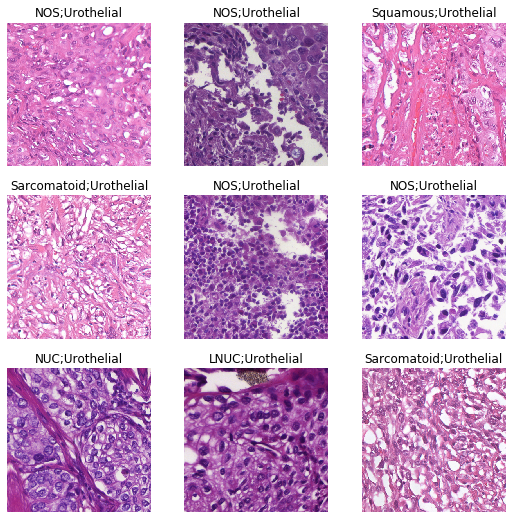

In [31]:
dls.show_batch()

# learner

## n

In [32]:
n=1

## create

In [33]:
arch = torchvision.models.resnet50

In [ ]:
learner = cnn_learner(dls=dls, 
                     arch=arch, 
                     metrics=[fastai.metrics.accuracy_multi],
                     pretrained=True,
                     path=PATH/'models'/f'{n}-{arch.__name__}')

In [36]:
learner.to_fp16()
learner.path
learner.path.parent.mkdir(exist_ok=True)
learner.path.mkdir(exist_ok=True)

## name

In [37]:
epochs_frozen = 5
epochs_unfrozen = 10

In [38]:
nameBase = f'{n}-{arch.__name__}'
nameBase

'1-resnet50'

## train

In [ ]:
learner.lr_find(start_lr=1e-15, end_lr=10, num_it=200)

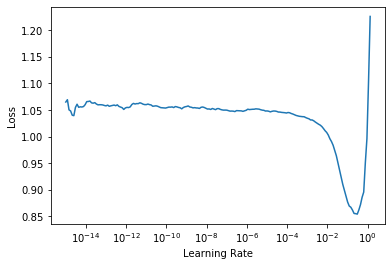

In [41]:
learner.recorder.plot_lr_find()

In [42]:
lr1 = 6e-1

In [43]:
log_head_name = 'log-head.csv'

In [ ]:
learner.fit_one_cycle(n_epoch=epochs_frozen, 
                      lr_max=lr1, 
                      cbs=[CSVLogger(fname=log_head_name, append=True), SaveModelCallback(every_epoch=True, fname='head')])

epoch,train_loss,valid_loss,accuracy_multi,time


In [ ]:
pd.read_csv(learner.path/log_head_name)